### Import required modules

In [31]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt  
plt.style.use('seaborn-whitegrid')

### Load and preprocess the data

In [32]:
### Load gene_acc to gene_name data file
acc2genename_df = pd.read_csv('./data/KPT-DMSO-NUC-CYTO.csv',
                             index_col = 0,
                             usecols=[0,1,8,9])

# Replace "Repeat" in column exon_count with NaN
acc2genename_df['exon_count'] = acc2genename_df['exon_count'].replace(["Repeat"], None)
acc2genename_df['exon_count'] = acc2genename_df['exon_count'].astype(int)


In [33]:
### Load RNAseq TPM data
tpm_df = pd.read_csv('./data/TPM_DMSO-KPT_nuc_cyto.csv', 
                     index_col=0, 
                     usecols=[0,2,3,4,8,9,10])


In [34]:
### Merge tpm_df + acc2genename_df
tpm_df = pd.concat([tpm_df,acc2genename_df], axis=1)


In [35]:
tpm_df['tpm_cyt'] = tpm_df[['cytoplasmic_dmso_3hrs_1','cytoplasmic_dmso_3hrs_2','cytoplasmic_dmso_3hrs_3']].mean(axis=1)
tpm_df['tpm_nuc']  = tpm_df[['nuclear_dmso_3hrs_1','nuclear_dmso_3hrs_2','nuclear_dmso_3hrs_3']].mean(axis=1)
tpm_df = tpm_df.drop(columns=['cytoplasmic_dmso_3hrs_1',
                     'cytoplasmic_dmso_3hrs_2',
                     'cytoplasmic_dmso_3hrs_3',
                     'nuclear_dmso_3hrs_1',
                     'nuclear_dmso_3hrs_2',
                     'nuclear_dmso_3hrs_3'])


In [36]:
# Add label "both" to flag genes detected in both nuclear and cyto fractions
def set_flag (row):
    cutoff = 1
    if (row.tpm_cyt >= cutoff) & (row.tpm_nuc >= cutoff):
        return 'both'
    elif row.tpm_cyt >= cutoff:
        return 'cyto_target'
    elif row.tpm_nuc >= cutoff:
        return 'nuc_target'
    else:
        return 'no'
        
#tpm_df.drop(columns='flag')
        
tpm_df['target_all'] = tpm_df.apply(set_flag, axis=1)
#tpm_df[(tpm_df['tpm_cyt'] > 0) & (tpm_df['tpm_nuc'] > 0)]['target'] = 'both'



In [37]:
# Add exon bins
bins = [0,1,5,10,15,20,30,1000]
labels = ['1','2-5','6-10','11-15','16-20','21-30','>30']
tpm_df['exon_group'] = pd.cut(tpm_df['exon_count'], bins=bins, labels=labels)



In [38]:
### Load parclip data
parclip_df = pd.read_excel('./data/103_Nuc_cyto_new.xlsx', index_col=1)


In [39]:
# Remove unnecessary columns
parclip_df = parclip_df.drop(columns=['Unnamed: 0', 'exon_count.x.x',
                            'gene_type.x.x', 'exon_count.y.x', 
                            'gene_type.y.x', 'exon_group.x',
                            'exon_count.x.y','gene_type.x.y']
               )

In [40]:
# Replace '-' with NAs
parclip_df = parclip_df.replace(to_replace='-', value=np.nan)

# Drop rows with all missing values
keep_index = parclip_df.loc[:,parclip_df.columns.str.contains(pat='_normal')] \
                .dropna(axis=0, how='all') \
                .index
parclip_df = parclip_df.loc[keep_index]



In [41]:
# Normalize column names
new_col_names = ['XL_all_nuc_norm', 'XL_exon_nuc_norm',
       'XL_coding_nuc_norm', 'XL_3utr_nuc_norm', '3utr_nuc_target',
       'nuc_target', 'XL_all_cyt_norm', 'XL_5utr_cyt_norm',
       'XL_intron_cyt_norm', 'XL_exon_cyt_norm', 'XL_coding_cyt_norm',
       'XL_3utr_cyt_norm', 'exon_count', 'gene_type',
       'exon_group', '3utr_cyt_target', 'cyt_target', '3utr_both_target',
       'target_all']
parclip_df.columns = new_col_names

# convert exon_counts to int
parclip_df.exon_count = parclip_df.exon_count.astype(int)


In [42]:
# Replace evon_group names
parclip_df['exon_group'] = pd.cut(parclip_df['exon_count'], bins=bins, labels=labels)

# Replace target flags to match tpm_df flags
def set_flag_pc (row):
    cutoff = 1
    if (row.nuc_target == 'nuc_target') & (row.cyt_target == 'cyto_target'):
        return 'both'
    elif row.cyt_target == 'cyto_target':
        return 'cyto_target'
    elif row.nuc_target == 'nuc_target':
        return 'nuc_target'
    else:
        return 'no'
        
#tpm_df.drop(columns='flag')
        
parclip_df['target_all'] = parclip_df.apply(set_flag_pc, axis=1)

### Filtering protein_coding + long_ncRNA genes

In [43]:
## Keep only protein_coding genes
tpm_df = tpm_df.query('broader_type == "protein_coding" | broader_type =="lncRNA"')
parclip_df = parclip_df.query('gene_type == "protein_coding" | gene_type =="lncRNA"')

## A) Present in both fractions

### A.1 Create plots for gene counts (target_all = both)

In [44]:
# Prepare gene counts
pc_nuc_counts_s = parclip_df.query('target_all=="both"').groupby('exon_count').XL_all_nuc_norm.count()
pc_cyt_counts_s = parclip_df.query('target_all=="both"').groupby('exon_count').XL_all_cyt_norm.count()

rnaseq_nuc_counts_s = tpm_df.query('target_all=="both"').groupby('exon_count').tpm_nuc.count()
rnaseq_cyt_counts_s = tpm_df.query('target_all=="both"').groupby('exon_count').tpm_cyt.count()

norm_counts_df = pd.concat([pc_nuc_counts_s,pc_cyt_counts_s,rnaseq_nuc_counts_s,rnaseq_cyt_counts_s], axis=1)
norm_counts_df.columns = ['parclip_nuc','parclip_cyt','rnaseq_nuc','rnaseq_cyt']

1- Gene counts vs exon counts (nuc)

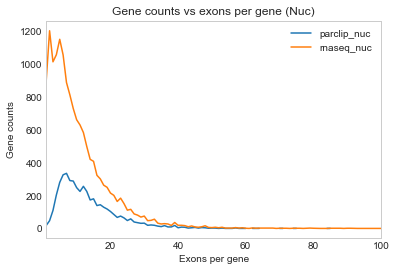

In [46]:
# Gene counts vs exon counts (NUC)
norm_counts_nuc_p = norm_counts_df.plot(y=['parclip_nuc','rnaseq_nuc'], 
                title='Gene counts vs exons per gene (Nuc)',
                xlabel='Exons per gene',
                ylabel='Gene counts',
                grid=False,
                xlim=(1,100))
fig = norm_counts_nuc_p.get_figure()
fig.savefig('./gene_counts_exons_per_gene_NUC.pdf')

2- Gene counts vs exon counts (cyt)

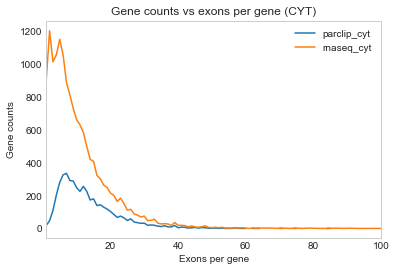

In [47]:
# Gene counts vs exon counts (CYT)
norm_counts_cyt_p = norm_counts_df.plot(y=['parclip_cyt','rnaseq_cyt'], 
                title='Gene counts vs exons per gene (CYT)',
                xlabel='Exons per gene',
                ylabel='Gene counts',
                grid=False,
                xlim=(1,100))
fig = norm_counts_cyt_p.get_figure()
fig.savefig('./gene_counts_exons_per_gene_CYT.pdf')

Calculate relative gene counts

In [48]:
# Calculate relative counts
norm_counts_df['parclip_nuc_perc'] = norm_counts_df.parclip_nuc * 100 / norm_counts_df.parclip_nuc.sum()
norm_counts_df['parclip_cyt_perc'] = norm_counts_df.parclip_cyt * 100 / norm_counts_df.parclip_cyt.sum()

norm_counts_df['rnaseq_nuc_perc'] = norm_counts_df.rnaseq_nuc * 100 / norm_counts_df.rnaseq_nuc.sum()
norm_counts_df['rnaseq_cyt_perc'] = norm_counts_df.rnaseq_cyt * 100 / norm_counts_df.rnaseq_cyt.sum()


3- Relative gene counts vs exon counts (nuc)

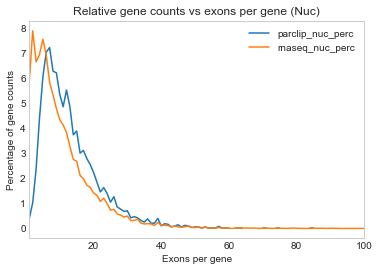

In [49]:
# Relative gene counts vs exon counts (NUC)
norm_counts_p = norm_counts_df.plot(y=['parclip_nuc_perc','rnaseq_nuc_perc'], 
                title='Relative gene counts vs exons per gene (Nuc)',
                xlabel='Exons per gene',
                ylabel='Percentage of gene counts',
                grid=False, 
                xlim=(1,100))
fig = norm_counts_p.get_figure()
fig.savefig('./percentage_gene_counts_exons_per_gene_NUC.pdf')

4- Relative gene counts vs exon counts (cyt)

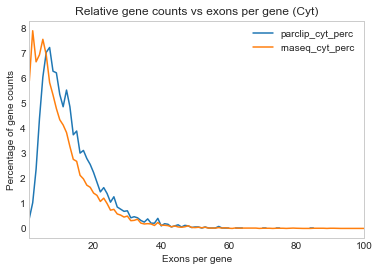

In [65]:
# Relative gene counts vs exon counts (CYT)
norm_counts_cyt_p = norm_counts_df.plot(y=['parclip_cyt_perc','rnaseq_cyt_perc'], 
                title='Relative gene counts vs exons per gene (Cyt)',
                xlabel='Exons per gene',
                ylabel='Percentage of gene counts',
                grid=False, 
                xlim=(1,100))
fig = norm_counts_cyt_p.get_figure()
fig.savefig('./percentage_gene_counts_exons_per_gene_CYT.pdf')

#### Create plots for normalized read counts (target_all = both)
Calculate read sums

In [51]:
# Normalized read counts
pc_nuc_sum_s = parclip_df.query('target_all=="both"').groupby('exon_count').XL_all_nuc_norm.sum()
pc_cyt_sum_s = parclip_df.query('target_all=="both"').groupby('exon_count').XL_all_cyt_norm.sum()

rnaseq_nuc_sum_s = tpm_df.query('target_all=="both"').groupby('exon_count').tpm_nuc.sum()
rnaseq_cyt_sum_s = tpm_df.query('target_all=="both"').groupby('exon_count').tpm_cyt.sum()

norm_sum_df = pd.concat([pc_nuc_sum_s,pc_cyt_sum_s,rnaseq_nuc_sum_s,rnaseq_cyt_sum_s], axis=1)
norm_sum_df.columns = ['parclip_nuc','parclip_cyt','rnaseq_nuc','rnaseq_cyt']


1- Read counts vs exon counts (nuc)

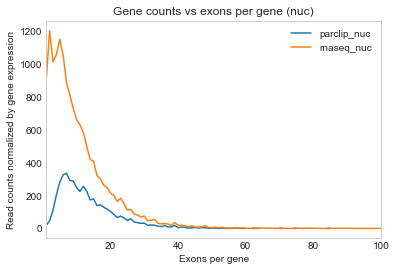

In [52]:
norm_sum_p = norm_counts_df.plot(y=['parclip_nuc','rnaseq_nuc'], 
                title='Gene counts vs exons per gene (nuc)',
                xlabel='Exons per gene',
                ylabel='Read counts normalized by gene expression',
                grid=False,
                xlim=(1,100))
fig = norm_sum_p.get_figure()
fig.savefig('./norm_read_counts_vs_exons_per_gene_NUC.pdf')

2- Read counts vs exon counts (cyt)

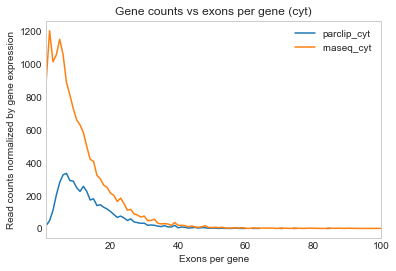

In [53]:
norm_sum_p = norm_counts_df.plot(y=['parclip_cyt','rnaseq_cyt'], 
                title='Gene counts vs exons per gene (cyt)',
                xlabel='Exons per gene',
                ylabel='Read counts normalized by gene expression',
                grid=False,
                xlim=(1,100))
fig = norm_sum_p.get_figure()
fig.savefig('./norm_read_counts_vs_exons_per_gene_CYT.pdf')

Calculate relative read counts

In [54]:
norm_sum_df['parclip_nuc_perc'] = norm_sum_df.parclip_nuc * 100 / norm_sum_df.parclip_nuc.sum()
norm_sum_df['parclip_cyt_perc'] = norm_sum_df.parclip_cyt * 100 / norm_sum_df.parclip_cyt.sum()

norm_sum_df['rnaseq_nuc_perc'] = norm_sum_df.rnaseq_nuc * 100 / norm_sum_df.rnaseq_nuc.sum()
norm_sum_df['rnaseq_cyt_perc'] = norm_sum_df.rnaseq_cyt * 100 / norm_sum_df.rnaseq_cyt.sum()

norm_sum_df

,parclip_nuc,parclip_cyt,rnaseq_nuc,rnaseq_cyt,parclip_nuc_perc,parclip_cyt_perc,rnaseq_nuc_perc,rnaseq_cyt_perc
exon_count,,,,,,,,
1,995.360597,10029.714522,66718.388873,91866.659707,0.169246,0.330674,8.296876,10.542500
2,2168.401029,17585.618334,53235.951635,48792.395274,0.368704,0.579787,6.620246,5.599353
3,10491.064165,67924.662061,37798.141178,45973.740522,1.783848,2.239435,4.700451,5.275887
4,28017.540844,158904.573234,46338.247681,57509.950785,4.763961,5.238988,5.762470,6.599768
5,29293.433915,239987.694702,51642.837125,65490.599707,4.980908,7.912250,6.422131,7.515617
...,...,...,...,...,...,...,...,...
105,NaN,NaN,82.627631,28.999373,NaN,NaN,0.010275,0.003328
106,85.950370,62.503217,125.653909,113.594153,0.014615,0.002061,0.015626,0.013036
116,18.576115,175.925562,86.931826,18.085532,0.003159,0.005800,0.010811,0.002075


3- Relative read counts vs exon counts (nuc)

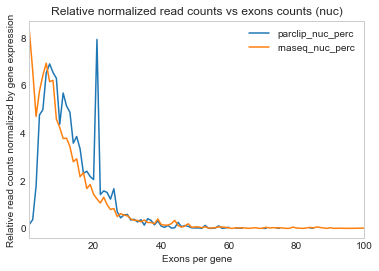

In [55]:
norm_sum_p = norm_sum_df.plot(y=['parclip_nuc_perc','rnaseq_nuc_perc'], 
                title='Relative normalized read counts vs exons counts (nuc)',
                xlabel='Exons per gene',
                ylabel='Relative read counts normalized by gene expression',
                grid=False,
                xlim=(1,100))
fig = norm_sum_p.get_figure()
fig.savefig('./relative_norm_read_counts_vs_exons_per_gene_NUC.pdf')

4- Relative read counts vs exon counts (cyt)

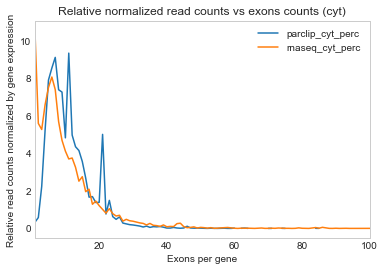

In [56]:
norm_sum_p = norm_sum_df.plot(y=['parclip_cyt_perc','rnaseq_cyt_perc'], 
                title='Relative normalized read counts vs exons counts (cyt)',
                xlabel='Exons per gene',
                ylabel='Relative read counts normalized by gene expression',
                grid=False,
                xlim=(1,100))
fig = norm_sum_p.get_figure()
fig.savefig('./relative_norm_read_counts_vs_exons_per_gene_CYT.pdf')

### A.2 Piechart plots gene counts (target_all = both)
1- Parclip nuclear

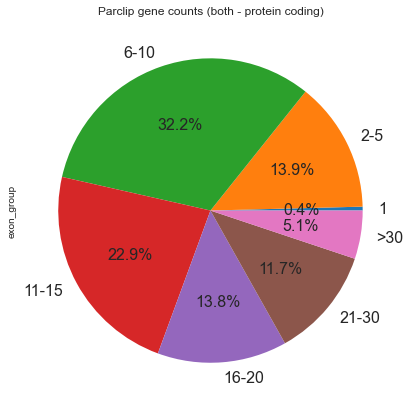

In [57]:
pc = parclip_df.query('target_all=="both"').groupby("exon_group")['exon_group']  \
    .count() \
    / len(parclip_df.query('target_all=="both"'))

pc_pie_p = pc.plot.pie(title='Parclip gene counts (both - protein coding)', normalize=False,
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig = pc_pie_p.get_figure()
fig.savefig('./piechart_gene_counts_vs_exons_per_gene_parclip_BOTH.pdf')


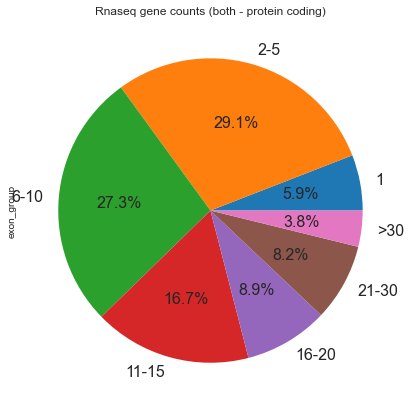

In [58]:
rnaseq = tpm_df.query('target_all=="both"').groupby("exon_group")['exon_group'] \
    .count() \
    / len(tpm_df.query('target_all=="both"'))

rnaseq_pie_p = rnaseq.plot.pie(title='Rnaseq gene counts (both - protein coding)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig = rnaseq_pie_p.get_figure()
fig.savefig('./piechart_gene_counts_vs_exons_per_gene_rnaseq_BOTH.pdf')


### A.3 Piechar plots of normalized read counts (nuc) (target_all = both)

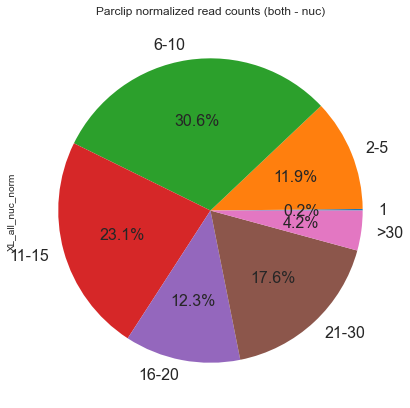

In [59]:
pc_rel = parclip_df.query('target_all=="both"').groupby("exon_group")['XL_all_nuc_norm']  \
    .sum() / parclip_df.query('target_all=="both"')['XL_all_nuc_norm'].count()

pc_rel_pie_p = pc_rel.plot.pie(title='Parclip normalized read counts (both - nuc)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig_pc_rel = pc_rel_pie_p.get_figure()
fig_pc_rel.savefig('./piechart_read_counts_vs_exons_per_gene_parclip_range_NUC_both.pdf')



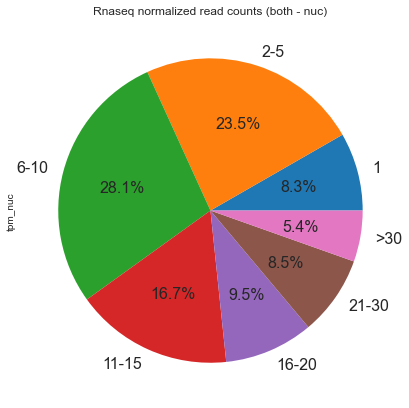

In [62]:
rnaseq_rel = tpm_df.query('target_all=="both"').groupby("exon_group")['tpm_nuc']  \
    .sum() / tpm_df.query('target_all=="both"')['tpm_nuc'].count()

rnaseq_rel_pie_p = rnaseq_rel.plot.pie(title='Rnaseq normalized read counts (both - nuc)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig_rnaseq_rel = rnaseq_rel_pie_p.get_figure()
fig_rnaseq_rel.savefig('./piechart_read_counts_vs_exons_per_gene_rnaseq_range_NUC_both.pdf')

### A.4 Piechar plots of normalized read counts (cyt) (target_all = both)

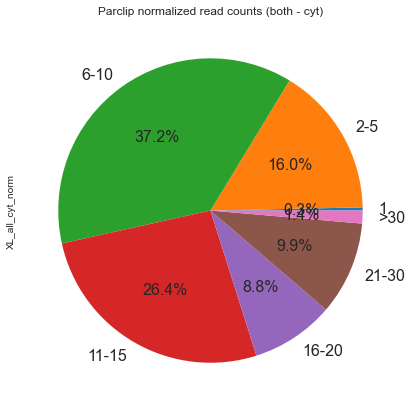

In [63]:
pc_rel = parclip_df.query('target_all=="both"').groupby("exon_group")['XL_all_cyt_norm']  \
    .sum() / parclip_df.query('target_all=="both"')['XL_all_cyt_norm'].count()

pc_rel_pie_p = pc_rel.plot.pie(title='Parclip normalized read counts (both - cyt)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig_pc_rel = pc_rel_pie_p.get_figure()
fig_pc_rel.savefig('./piechart_read_counts_vs_exons_per_gene_parclip_range_CYT_both.pdf')



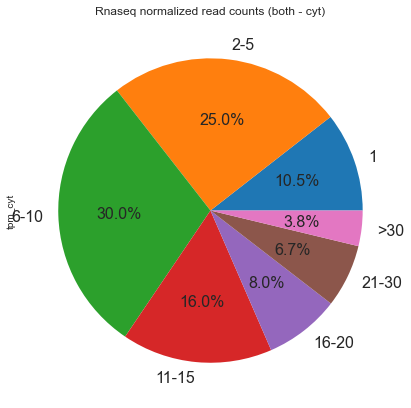

In [64]:
rnaseq_rel = tpm_df.query('target_all=="both"').groupby("exon_group")['tpm_cyt']  \
    .sum() / tpm_df.query('target_all=="both"')['tpm_cyt'].count()

rnaseq_rel_pie_p = rnaseq_rel.plot.pie(title='Rnaseq normalized read counts (both - cyt)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig_rnaseq_rel = rnaseq_rel_pie_p.get_figure()
fig_rnaseq_rel.savefig('./piechart_read_counts_vs_exons_per_gene_rnaseq_range_CYT_both.pdf')



## B) Nuclear fraction

In [113]:
path_nuclear = 'Plots/NUC_ALL/'

### B.1 Create plots for gene counts (target_all = both + nuc_target)

In [114]:
# Prepare gene counts
pc_nuc_counts_s = parclip_df.query('target_all=="both" | target_all=="nuc_target"').groupby('exon_count').XL_all_nuc_norm.count()

rnaseq_nuc_counts_s = tpm_df.query('target_all=="both" | target_all=="nuc_target"').groupby('exon_count').tpm_nuc.count()

norm_counts_df = pd.concat([pc_nuc_counts_s,rnaseq_nuc_counts_s], axis=1)
norm_counts_df.columns = ['parclip_nuc','rnaseq_nuc']

1- Gene counts vs exon counts (nuc)

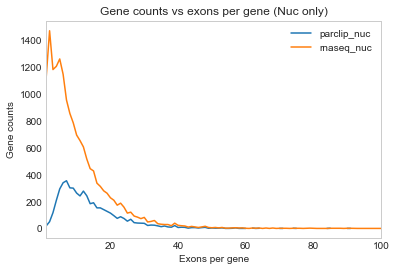

In [115]:
# Gene counts vs exon counts (NUC)
norm_counts_nuc_p = norm_counts_df.plot(y=['parclip_nuc','rnaseq_nuc'], 
                title='Gene counts vs exons per gene (Nuc only)',
                xlabel='Exons per gene',
                ylabel='Gene counts',
                grid=False,
                xlim=(1,100))
fig = norm_counts_nuc_p.get_figure()
fig.savefig('./'+path_nuclear+'gene_counts_exons_per_gene_NUC_ONLY.pdf')

2- Gene counts vs exon counts (cyt)

Calculate relative gene counts

In [116]:
# Calculate relative counts
norm_counts_df['parclip_nuc_perc'] = norm_counts_df.parclip_nuc * 100 / norm_counts_df.parclip_nuc.sum()

norm_counts_df['rnaseq_nuc_perc'] = norm_counts_df.rnaseq_nuc * 100 / norm_counts_df.rnaseq_nuc.sum()


3- Relative gene counts vs exon counts (nuc)

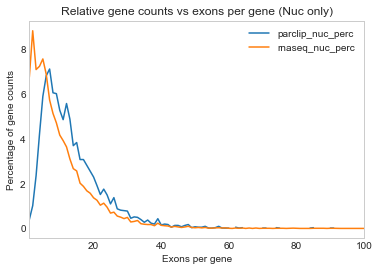

In [117]:
# Relative gene counts vs exon counts (NUC)
norm_counts_p = norm_counts_df.plot(y=['parclip_nuc_perc','rnaseq_nuc_perc'], 
                title='Relative gene counts vs exons per gene (Nuc only)',
                xlabel='Exons per gene',
                ylabel='Percentage of gene counts',
                grid=False, 
                xlim=(1,100))
fig = norm_counts_p.get_figure()
fig.savefig('./'+path_nuclear+'percentage_gene_counts_exons_per_gene_NUC_ONLY.pdf')

#### Create plots for normalized read counts (target_all = both + nuc_taget)
Calculate read sums

In [118]:
# Normalized read counts
pc_nuc_sum_s = parclip_df.query('target_all=="both" | target_all=="nuc_target"').groupby('exon_count').XL_all_nuc_norm.sum()

rnaseq_nuc_sum_s = tpm_df.query('target_all=="both" | target_all=="nuc_target"').groupby('exon_count').tpm_nuc.sum()

norm_sum_df = pd.concat([pc_nuc_sum_s,rnaseq_nuc_sum_s], axis=1)
norm_sum_df.columns = ['parclip_nuc','rnaseq_nuc']


1- Read counts vs exon counts (nuc)

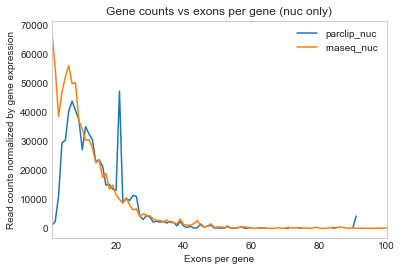

In [119]:
norm_sum_p = norm_sum_df.plot(y=['parclip_nuc','rnaseq_nuc'], 
                title='Gene counts vs exons per gene (nuc only)',
                xlabel='Exons per gene',
                ylabel='Read counts normalized by gene expression',
                grid=False,
                xlim=(1,100))
fig = norm_sum_p.get_figure()
fig.savefig('./'+path_nuclear+'norm_read_counts_vs_exons_per_gene_NUC_ONLY.pdf')

2- Read counts vs exon counts (cyt)

Calculate relative read counts

In [120]:
norm_sum_df['parclip_nuc_perc'] = norm_sum_df.parclip_nuc * 100 / norm_sum_df.parclip_nuc.sum()

norm_sum_df['rnaseq_nuc_perc'] = norm_sum_df.rnaseq_nuc * 100 / norm_sum_df.rnaseq_nuc.sum()


3- Relative read counts vs exon counts (nuc)

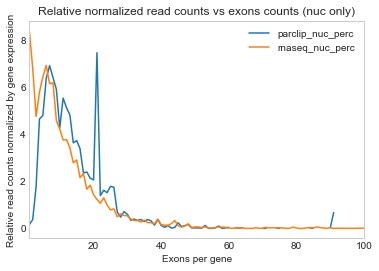

In [121]:
norm_sum_p = norm_sum_df.plot(y=['parclip_nuc_perc','rnaseq_nuc_perc'], 
                title='Relative normalized read counts vs exons counts (nuc only)',
                xlabel='Exons per gene',
                ylabel='Relative read counts normalized by gene expression',
                grid=False,
                xlim=(1,100))
fig = norm_sum_p.get_figure()
fig.savefig('./'+path_nuclear+'relative_norm_read_counts_vs_exons_per_gene_NUC_ONLY.pdf')

### B.2 Piechart plots gene counts (target_all = both + nuc_target)
1- Parclip nuclear

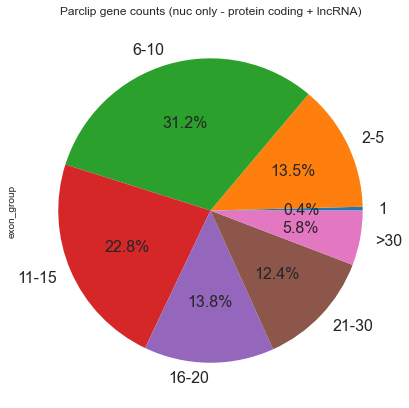

In [122]:
pc = parclip_df.query('target_all=="both" | target_all=="nuc_target"').groupby("exon_group")['exon_group']  \
    .count() \
    / len(parclip_df.query('target_all=="both" | target_all=="nuc_target"'))

pc_pie_p = pc.plot.pie(title='Parclip gene counts (nuc only - protein coding + lncRNA)', normalize=False,
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig = pc_pie_p.get_figure()
fig.savefig('./'+path_nuclear+'piechart_gene_counts_vs_exons_per_gene_parclip_NUC_ONLY.pdf')


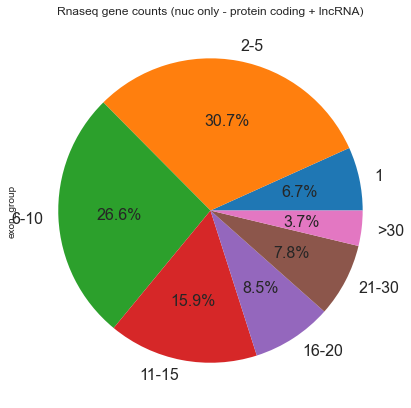

In [123]:
rnaseq = tpm_df.query('target_all=="both" | target_all=="nuc_target"').groupby("exon_group")['exon_group'] \
    .count() \
    / len(tpm_df.query('target_all=="both" | target_all=="nuc_target"'))

rnaseq_pie_p = rnaseq.plot.pie(title='Rnaseq gene counts (nuc only - protein coding + lncRNA)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig = rnaseq_pie_p.get_figure()
fig.savefig('./'+path_nuclear+'piechart_gene_counts_vs_exons_per_gene_rnaseq_NUC_ONLY.pdf')


### B.3 Piechar plots of normalized read counts (nuc) (target_all = both + nuc_target)

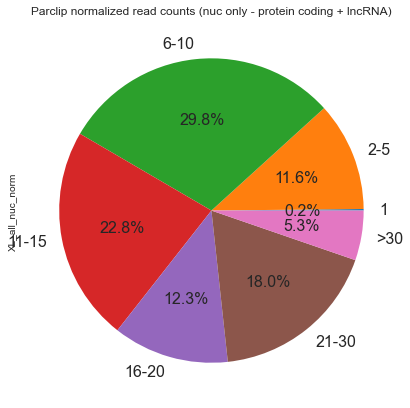

In [124]:
pc_rel = parclip_df.query('target_all=="both" | target_all=="nuc_target"').groupby("exon_group")['XL_all_nuc_norm']  \
    .sum() / parclip_df.query('target_all=="both" | target_all=="nuc_target"')['XL_all_nuc_norm'].count()

pc_rel_pie_p = pc_rel.plot.pie(title='Parclip normalized read counts (nuc only - protein coding + lncRNA)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig_pc_rel = pc_rel_pie_p.get_figure()
fig_pc_rel.savefig('./'+path_nuclear+'piechart_read_counts_vs_exons_per_gene_parclip_range_NUC_ONLY.pdf')



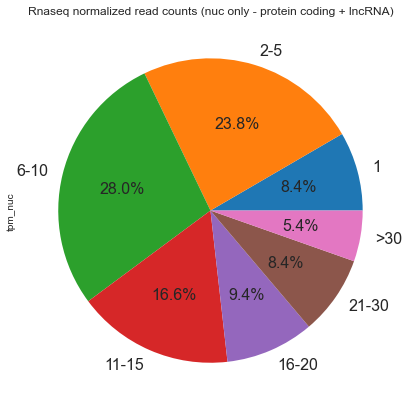

In [125]:
rnaseq_rel = tpm_df.query('target_all=="both" | target_all=="nuc_target"').groupby("exon_group")['tpm_nuc']  \
    .sum() / tpm_df.query('target_all=="both" | target_all=="nuc_target"')['tpm_nuc'].count()

rnaseq_rel_pie_p = rnaseq_rel.plot.pie(title='Rnaseq normalized read counts (nuc only - protein coding + lncRNA)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig_rnaseq_rel = rnaseq_rel_pie_p.get_figure()
fig_rnaseq_rel.savefig('./'+path_nuclear+'piechart_read_counts_vs_exons_per_gene_rnaseq_range_NUC_ONLY.pdf')

## C) Cytoplasmic fraction

In [126]:
path_cyt = 'Plots/CYT_ALL/'

### C.1 Create plots for gene counts (target_all = both + cyt_target)

In [127]:
# Prepare gene counts
pc_cyt_counts_s = parclip_df.query('target_all=="both" | target_all=="cyt_target"').groupby('exon_count').XL_all_cyt_norm.count()

rnaseq_cyt_counts_s = tpm_df.query('target_all=="both" | target_all=="cyt_target"').groupby('exon_count').tpm_cyt.count()

norm_counts_df = pd.concat([pc_cyt_counts_s,rnaseq_cyt_counts_s], axis=1)
norm_counts_df.columns = ['parclip_cyt','rnaseq_cyt']

1- Gene counts vs exon counts (cyt)

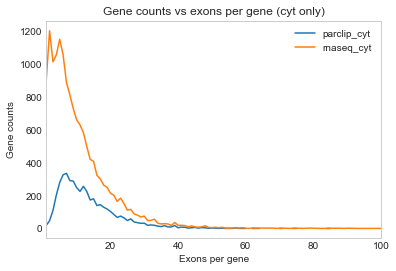

In [128]:
# Gene counts vs exon counts (cyt)
norm_counts_cyt_p = norm_counts_df.plot(y=['parclip_cyt','rnaseq_cyt'], 
                title='Gene counts vs exons per gene (cyt only)',
                xlabel='Exons per gene',
                ylabel='Gene counts',
                grid=False,
                xlim=(1,100))
fig = norm_counts_cyt_p.get_figure()
fig.savefig('./'+path_cyt+'/gene_counts_exons_per_gene_cyt_ONLY.pdf')

Calculate relative gene counts

In [129]:
# Calculate relative counts
norm_counts_df['parclip_cyt_perc'] = norm_counts_df.parclip_cyt * 100 / norm_counts_df.parclip_cyt.sum()

norm_counts_df['rnaseq_cyt_perc'] = norm_counts_df.rnaseq_cyt * 100 / norm_counts_df.rnaseq_cyt.sum()


2- Relative gene counts vs exon counts (cyt)

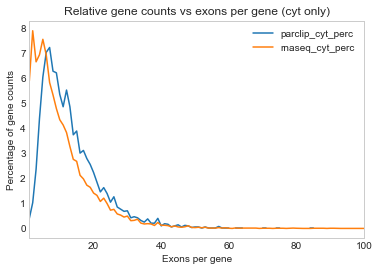

In [130]:
# Relative gene counts vs exon counts (cyt)
norm_counts_p = norm_counts_df.plot(y=['parclip_cyt_perc','rnaseq_cyt_perc'], 
                title='Relative gene counts vs exons per gene (cyt only)',
                xlabel='Exons per gene',
                ylabel='Percentage of gene counts',
                grid=False, 
                xlim=(1,100))
fig = norm_counts_p.get_figure()
fig.savefig('./'+path_cyt+'percentage_gene_counts_exons_per_gene_cyt_ONLY.pdf')

#### Create plots for normalized read counts (target_all = both + cyt_taget)
Calculate read sums

In [131]:
# Normalized read counts
pc_cyt_sum_s = parclip_df.query('target_all=="both" | target_all=="cyt_target"').groupby('exon_count').XL_all_cyt_norm.sum()

rnaseq_cyt_sum_s = tpm_df.query('target_all=="both" | target_all=="cyt_target"').groupby('exon_count').tpm_cyt.sum()

norm_sum_df = pd.concat([pc_cyt_sum_s,rnaseq_cyt_sum_s], axis=1)
norm_sum_df.columns = ['parclip_cyt','rnaseq_cyt']


1- Read counts vs exon counts (cyt)

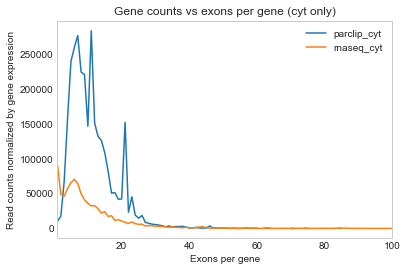

In [132]:
norm_sum_p = norm_sum_df.plot(y=['parclip_cyt','rnaseq_cyt'], 
                title='Gene counts vs exons per gene (cyt only)',
                xlabel='Exons per gene',
                ylabel='Read counts normalized by gene expression',
                grid=False,
                xlim=(1,100))
fig = norm_sum_p.get_figure()
fig.savefig('./'+path_cyt+'norm_read_counts_vs_exons_per_gene_cyt_ONLY.pdf')

Calculate relative read counts

In [133]:
norm_sum_df['parclip_cyt_perc'] = norm_sum_df.parclip_cyt * 100 / norm_sum_df.parclip_cyt.sum()

norm_sum_df['rnaseq_cyt_perc'] = norm_sum_df.rnaseq_cyt * 100 / norm_sum_df.rnaseq_cyt.sum()


In [160]:
norm_sum_df.loc[18:28,'parclip_cyt_perc']

exon_count
18    1.695187
19    1.380256
20    1.393315
21    5.015321
22    0.767203
23    1.495295
24    0.629524
25    0.484394
26    0.614347
27    0.285334
28    0.242363
Name: parclip_cyt_perc, dtype: float64

3- Relative read counts vs exon counts (cyt)

In [161]:
parclip_df.query('target_all=="both" | target_all=="cyt_target"') \
    .groupby('exon_count') \
    .XL_all_cyt_norm \
    .get_group(23).sort_values().tail(20)

gene_name
UBE3C        338.739389
NUP153       348.096962
XPO4         354.666095
WDR36        366.517989
FBXO11       378.825820
XRCC5        410.252457
TNRC6C       424.687892
SCLT1        440.614683
EPB41L3      494.683918
KDM2B        529.447203
ARNT         571.581712
ANKAR        582.316088
KANSL3       688.105694
TCERG1       748.911134
ALMS1        817.305642
DIS3        1013.156732
FOXP1       1120.355096
NCOA2       1186.979084
FOXP2       1904.977271
RPS6KA2    26372.821850
Name: XL_all_cyt_norm, dtype: float64

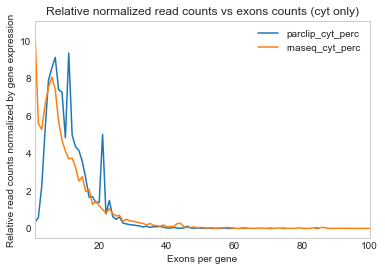

In [135]:
norm_sum_p = norm_sum_df.plot(y=['parclip_cyt_perc','rnaseq_cyt_perc'], 
                title='Relative normalized read counts vs exons counts (cyt only)',
                xlabel='Exons per gene',
                ylabel='Relative read counts normalized by gene expression',
                grid=False,
                xlim=(1,100))
fig = norm_sum_p.get_figure()
fig.savefig('./'+path_cyt+'relative_norm_read_counts_vs_exons_per_gene_cyt_ONLY.pdf')

### C.2 Piechart plots gene counts (target_all = both + cyt_target)
1- Parclip cytoplasm

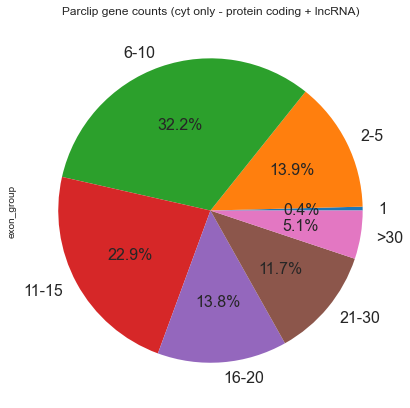

In [136]:
pc = parclip_df.query('target_all=="both" | target_all=="cyt_target"').groupby("exon_group")['exon_group']  \
    .count() \
    / len(parclip_df.query('target_all=="both" | target_all=="cyt_target"'))

pc_pie_p = pc.plot.pie(title='Parclip gene counts (cyt only - protein coding + lncRNA)', normalize=False,
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig = pc_pie_p.get_figure()
fig.savefig('./'+path_cyt+'piechart_gene_counts_vs_exons_per_gene_parclip_cyt_ONLY.pdf')


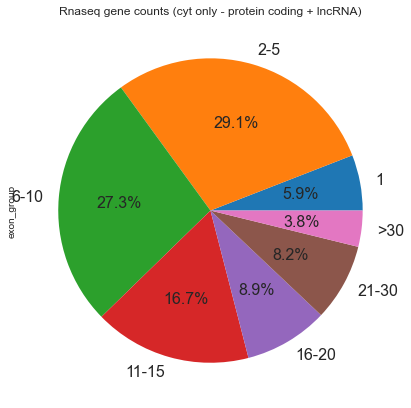

In [137]:
rnaseq = tpm_df.query('target_all=="both" | target_all=="cyt_target"').groupby("exon_group")['exon_group'] \
    .count() \
    / len(tpm_df.query('target_all=="both" | target_all=="cyt_target"'))

rnaseq_pie_p = rnaseq.plot.pie(title='Rnaseq gene counts (cyt only - protein coding + lncRNA)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig = rnaseq_pie_p.get_figure()
fig.savefig('./'+path_cyt+'piechart_gene_counts_vs_exons_per_gene_rnaseq_cyt_ONLY.pdf')


### C.3 Piechar plots of normalized read counts (cyt) (target_all = both + cyt_target)

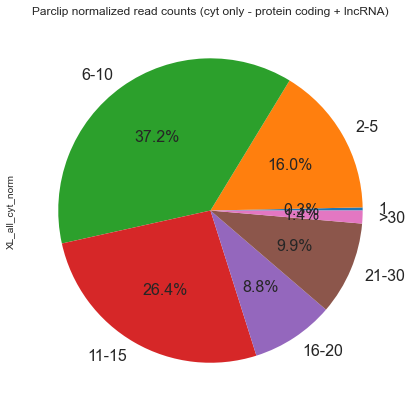

In [138]:
pc_rel = parclip_df.query('target_all=="both" | target_all=="cyt_target"').groupby("exon_group")['XL_all_cyt_norm']  \
    .sum() / parclip_df.query('target_all=="both" | target_all=="cyt_target"')['XL_all_cyt_norm'].count()

pc_rel_pie_p = pc_rel.plot.pie(title='Parclip normalized read counts (cyt only - protein coding + lncRNA)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig_pc_rel = pc_rel_pie_p.get_figure()
fig_pc_rel.savefig('./'+path_cyt+'piechart_read_counts_vs_exons_per_gene_parclip_range_cyt_ONLY.pdf')



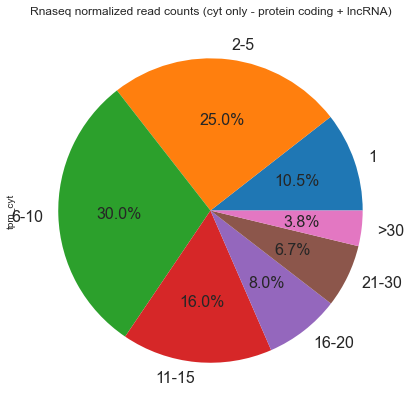

In [139]:
rnaseq_rel = tpm_df.query('target_all=="both" | target_all=="cyt_target"').groupby("exon_group")['tpm_cyt']  \
    .sum() / tpm_df.query('target_all=="both" | target_all=="cyt_target"')['tpm_cyt'].count()

rnaseq_rel_pie_p = rnaseq_rel.plot.pie(title='Rnaseq normalized read counts (cyt only - protein coding + lncRNA)', 
            autopct='%1.1f%%', 
            figsize=(7,7), 
            fontsize=16)
fig_rnaseq_rel = rnaseq_rel_pie_p.get_figure()
fig_rnaseq_rel.savefig('./'+path_cyt+'piechart_read_counts_vs_exons_per_gene_rnaseq_range_cyt_ONLY.pdf')